# Tutorial Assignment 2

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics  # use existing libraries!

In [3]:
# score function: binary cross entropy loss
def score_yp(y, p): # y, p are numpy arrays
    return sklearn.metrics.log_loss(y, p)

In [4]:
# score wrapper, for data frames. we need this when using the `truth` data frame
def score(x, y): # x, y are data frames
    xy = pd.merge(x, y, on=["customer", "product", "week"])
    assert xy.shape[0] == x.shape[0]
    return score_yp(xy["y"].values, xy["probability"].values)

<br>

## Input

In [5]:
# the path that contains the data
path = os.path.expandvars("~/Dropbox_RSM/teaching/big-data-23-24/data/dr-s")

In [6]:
# INPUT
training_week = 88  # for model training
validation_week = 89  # for model and baseline validation
test_week = 90  # for the final prediction (one week in the future, beyond our data)
target_customers = list(range(2000))
target_products = list(range(250))

<br>

## Load data

In [7]:
baskets = pd.read_parquet(f"{path}/upload/baskets-s.parquet")
# we only keep the 2000 customers required for the test set
# a complex model might require more data, e.g., see Boosted Tree model in Gabel & Timoshenko (2022)
baskets.head()

,week,customer,product,price
0,0,0,71,629
1,0,0,91,605
2,0,0,116,715
3,0,0,123,483
4,0,0,157,592


In [8]:
prediction_index = pd.read_parquet(f"{path}/raw/prediction_index.parquet")
prediction_index.head()

,week,customer,product
0,90,0,0
1,90,0,1
2,90,0,2
3,90,0,3
4,90,0,4


<br>

## EDA

In [9]:
baskets.describe()

,week,customer,product,price
count,1.378720e+06,1.378720e+06,1.378720e+06,1.378720e+06
mean,4.447746e+01,9.972110e+02,1.250727e+02,5.843381e+02
std,2.597662e+01,5.762501e+02,6.970123e+01,9.743281e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,2.340000e+02
25%,2.200000e+01,4.990000e+02,6.600000e+01,5.060000e+02
50%,4.400000e+01,9.930000e+02,1.230000e+02,5.790000e+02
75%,6.700000e+01,1.496000e+03,1.890000e+02,6.540000e+02
max,8.900000e+01,1.999000e+03,2.490000e+02,8.370000e+02


In [10]:
baskets["week"].max()

89

In [11]:
baskets["customer"].nunique()

2000

In [12]:
baskets["week"].nunique()

90

In [13]:
baskets["product"].nunique()

250

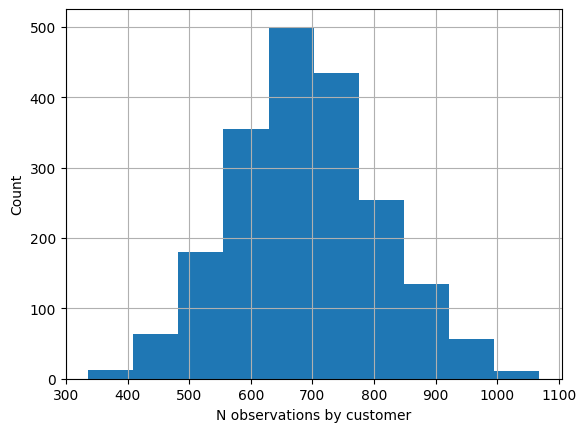

In [14]:
baskets.groupby("customer").size().hist()
plt.xlabel("N observations by customer")
plt.ylabel("Count")
plt.show()

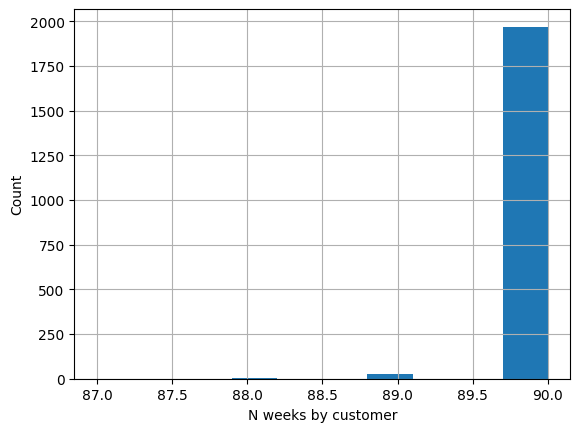

In [15]:
baskets.groupby("customer")["week"].nunique().hist()
plt.xlabel("N weeks by customer")
plt.ylabel("Count")
plt.show()

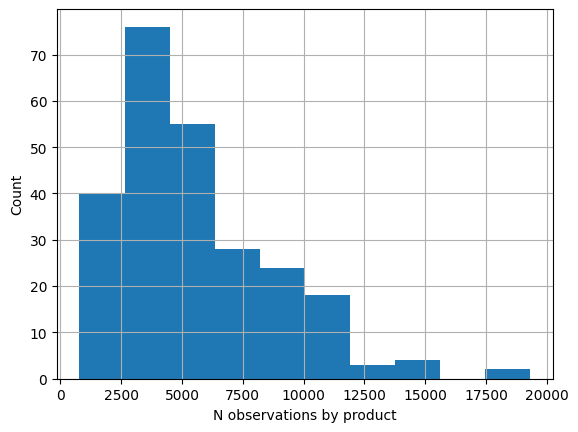

In [16]:
baskets.groupby("product").size().hist()
plt.xlabel("N observations by product")
plt.ylabel("Count")
plt.show()

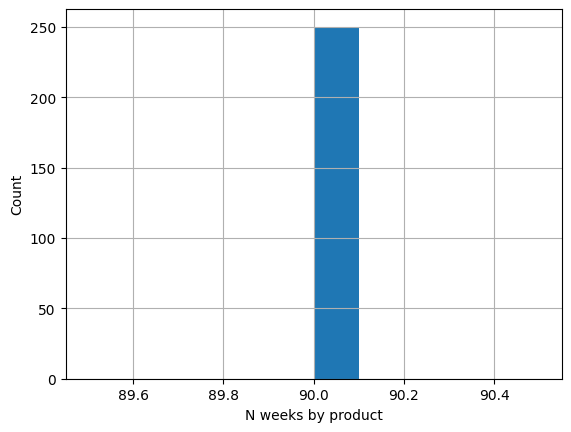

In [17]:
baskets.groupby("product")["week"].nunique().hist()
plt.xlabel("N weeks by product")
plt.ylabel("Count")
plt.show()

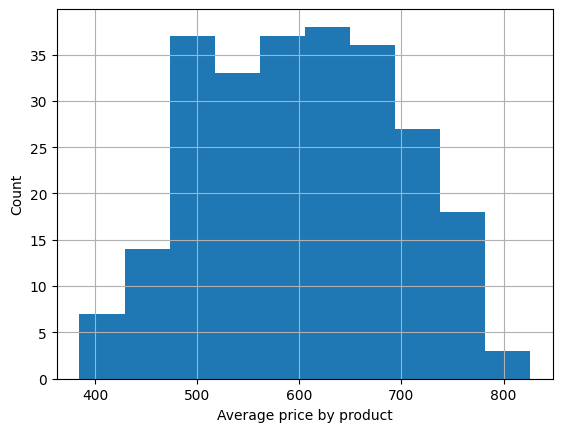

In [18]:
baskets.groupby("product")["price"].mean().hist()
plt.xlabel("Average price by product")
plt.ylabel("Count")
plt.show()

<br>

## Reminder

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/time-split.png" width="900"/>

<br>

## Some first steps

In [19]:
baskets.week.max()

89

In [20]:
n_weeks = baskets.week.nunique()
print(n_weeks)

90


In [21]:
# purchase frequency for one customer and product
(
    baskets[(baskets["customer"]==0) & (baskets["product"]==4)]
    .week.count()
    / n_weeks
)

0.08888888888888889

In [22]:
# this is our first "model" – wow, that's easy!
purchase_frequency_ij = (
    (
        baskets.groupby(["customer", "product"])
        [["week"]].count()
        / n_weeks
    )
    .rename(columns={"week": "probability"})
    .reset_index()
)
purchase_frequency_ij

,customer,product,probability
0,0,4,0.088889
1,0,11,0.100000
2,0,15,0.011111
3,0,16,0.044444
4,0,21,0.011111
...,...,...,...
142059,1999,237,0.044444
142060,1999,242,0.388889
142061,1999,243,0.011111
142062,1999,245,0.133333


In [23]:
test_week

90

In [24]:
# add all missing values
# Q1: what values are missing?
# Q2: what is a good value for probabilities here?
df = pd.DataFrame(
    {
        "week": test_week,
        "customer": np.repeat(target_customers, len(target_products), axis=0),
        "product": target_products * len(target_customers),
    }
)
df

,week,customer,product
0,90,0,0
1,90,0,1
2,90,0,2
3,90,0,3
4,90,0,4
...,...,...,...
499995,90,1999,245
499996,90,1999,246
499997,90,1999,247
499998,90,1999,248


In [25]:
result_baseline = pd.merge(
    df,
    purchase_frequency_ij,
    on=["customer", "product"],
    how="left",
).fillna(0)
result_baseline

,week,customer,product,probability
0,90,0,0,0.000000
1,90,0,1,0.000000
2,90,0,2,0.000000
3,90,0,3,0.000000
4,90,0,4,0.088889
...,...,...,...,...
499995,90,1999,245,0.133333
499996,90,1999,246,0.000000
499997,90,1999,247,0.000000
499998,90,1999,248,0.000000


<br>

## SOLUTION 1: Descriptive feature (past purchase rates) = Baseline

Now we have predictions, but we have no idea how good this baseline is.  So let's do the following:
1. construct a ground truth data set
1. do a proper train/validation split
1. predict purchase probabilities using our baseline
1. evaluate the predictions vs. the base

### Validation

In [26]:
# function to define target variable for all customer-product combinations (in a given week)
def build_target(baskets, week):

    baskets_week = baskets[baskets["week"] == week][
        ["week", "customer", "product"]
    ].reset_index(drop=True)
    baskets_week["y"] = 1

    df = pd.DataFrame(
        {
            "week": week,
            "customer": np.repeat(target_customers, len(target_products), axis=0),
            "product": target_products * len(target_customers),
        }
    )

    df = df.merge(baskets_week, on=["week", "customer", "product"], how="left")
    df["y"] = df["y"].fillna(0).astype(int)

    return df

In [27]:
validation_week

89

In [28]:
baseline_target = build_target(baskets, validation_week)
baseline_target.head()

,week,customer,product,y
0,89,0,0,0
1,89,0,1,0
2,89,0,2,0
3,89,0,3,0
4,89,0,4,0


In [29]:
baseline_target.describe()

,week,customer,product,y
count,500000.0,500000.000000,500000.000000,500000.000000
mean,89.0,999.500000,124.500000,0.030386
std,0.0,577.350774,72.168278,0.171647
min,89.0,0.000000,0.000000,0.000000
25%,89.0,499.750000,62.000000,0.000000
50%,89.0,999.500000,124.500000,0.000000
75%,89.0,1499.250000,187.000000,0.000000
max,89.0,1999.000000,249.000000,1.000000


In [30]:
# the perfect prediction has a loss of 0
score_yp(baseline_target.y.values, baseline_target.y.values)

2.2204460492503136e-16

In [31]:
# wrap code into function:
# baseline = purchase rates for customer-product combinations before the target week
def baseline_prediction(baskets, week):

    # subset baskets
    baskets_t = baskets[baskets["week"] < week].reset_index(drop=True)
    n_weeks = baskets_t.week.nunique()
    print(n_weeks)

    # model (non-0 probabilities)
    purchase_frequency_ij = (
        (baskets_t.groupby(["customer", "product"])[["week"]].count() / n_weeks)
        .rename(columns={"week": "probability"})
        .reset_index()
    )

    # filling in 0s
    df = pd.DataFrame(
        {
            "week": week,
            "customer": np.repeat(target_customers, len(target_products), axis=0),
            "product": target_products * len(target_customers),
        }
    )

    result_baseline = pd.merge(
        df,
        purchase_frequency_ij,
        on=["customer", "product"],
        how="left",
    ).fillna(0)

    return result_baseline

In [32]:
# prediction for validation data
baseline_validation = baseline_prediction(baskets, validation_week)
baseline_validation.head()

89


,week,customer,product,probability
0,89,0,0,0.000000
1,89,0,1,0.000000
2,89,0,2,0.000000
3,89,0,3,0.000000
4,89,0,4,0.089888


In [33]:
baseline_target

,week,customer,product,y
0,89,0,0,0
1,89,0,1,0
2,89,0,2,0
3,89,0,3,0
4,89,0,4,0
...,...,...,...,...
499995,89,1999,245,1
499996,89,1999,246,0
499997,89,1999,247,0
499998,89,1999,248,0


In [34]:
baseline_validation

,week,customer,product,probability
0,89,0,0,0.000000
1,89,0,1,0.000000
2,89,0,2,0.000000
3,89,0,3,0.000000
4,89,0,4,0.089888
...,...,...,...,...
499995,89,1999,245,0.123596
499996,89,1999,246,0.000000
499997,89,1999,247,0.000000
499998,89,1999,248,0.000000


In [35]:
# score for validation data
score(baseline_target, baseline_validation)

0.10165261879837957

### Test

In [36]:
validation_week + 1

90

In [37]:
test_week

90

In [38]:
# prediction for test data
# we can't evaluate this
baseline_test = baseline_prediction(baskets, test_week)
baseline_test.head()

90


,week,customer,product,probability
0,90,0,0,0.000000
1,90,0,1,0.000000
2,90,0,2,0.000000
3,90,0,3,0.000000
4,90,0,4,0.088889


Conclusion:
1. Train model to week 88, evaluate predictions for week 89 with truth data 
1. Predict week 90, and submit

<br>

## Score on test set

In real life, never load your test/validation data durnig model training!

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/danger-zone.gif" width="800"/>

In [39]:
# true purchases in week 90
truth = pd.read_parquet(f"{path}/private/truth.parquet")

In [40]:
score(truth, baseline_test)

0.10136217573628638

<br>
<br>

<b>Learning from Big Data</b> <br>
Sebastian Gabel <br>